<a href="https://colab.research.google.com/github/dmosh/building_density/blob/main/building_density_resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading neccessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import re
import io
import shutil
from google.cloud import storage
import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Flatten, GlobalAveragePooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Dropout

In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#!pip install gsutil
#!curl http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true
!gcloud auth login

In [ ]:
# Create a Cloud Storage client
storage_client = storage.Client()

# Get the bucket where the training data is stored
bucket = storage_client.bucket('xcob-bucket-1')

# Get the object where the training data is stored
object_training = bucket.blob('dataset/training/training.csv')

# Download the training data from Cloud Storage
training_data = object_training.download_as_string().decode('utf-8')

# Create a StringIO object from the training data
with io.StringIO(training_data) as f:
    training = pd.read_csv(f)

# Get the object where the validation data is stored
object_testing = bucket.blob('dataset/test/testing.csv')

# Download the validation data from Cloud Storage
testing_data = object_testing.download_as_string().decode('utf-8')

# Create a StringIO object from the validation data
with io.StringIO(testing_data) as f:
    testing = pd.read_csv(f)


# Get the object where the testing data is stored
object_test = bucket.blob('dataset/samples/samples.csv')

# Download the testing data from Cloud Storage
test_data = object_test.download_as_string().decode('utf-8')

# Create a StringIO object from the testing data
with io.StringIO(test_data) as f:
    test = pd.read_csv(f)

In [ ]:
#training.head()
test.head()
#print(training.shape)
#print(testing.shape)


,input,label
0,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
1,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
2,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
3,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...
4,dataset/samples/Sentinel2_image_fortportal2019...,dataset/samples/Sentinel2_image_fortportal2019...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
#Access sample images
# Access the "input" and "label" columns
input_paths = training["input"]
label_paths = training["label"]

#Access validation images
tinput_paths = testing["input"]
tlabel_paths = testing["label"]

In [ ]:
# Initialize a client to interact with GCS
client = storage.Client()

def visualize_random_image_pair(input_paths, label_paths):
    # Select a random index
    random_index = random.randint(0, len(input_paths) - 1)

    # Get the image paths at the random index
    input_path = input_paths[random_index]
    label_path = label_paths[random_index]

    # Extract file names from image paths
    input_filename = os.path.basename(input_path)
    label_filename = os.path.basename(label_path)

    # Load images from GCS
    input_blob = client.get_bucket('xcob-bucket-1').blob(input_path)
    label_blob = client.get_bucket('xcob-bucket-1').blob(label_path)

    # Download image data from GCS
    input_image_data = input_blob.download_as_string()
    label_image_data = label_blob.download_as_string()

    # Decode the image data using OpenCV
    img1 = cv2.imdecode(np.frombuffer(input_image_data, np.uint8), -1)
    img2 = cv2.imdecode(np.frombuffer(label_image_data, np.uint8), -1)

    # Plot the random image pair with titles
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{input_filename}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{label_filename}")
    plt.axis("off")
    plt.show()

# Read the CSV file into a DataFrame
df = pd.read_csv('dataset/training/training.csv')

# Extract the input and label paths from the DataFrame
input_paths = df['input'].tolist()
label_paths = df['label'].tolist()

# Visualize a random pair of images from the training data
visualize_random_image_pair(input_paths, label_paths)


In [ ]:
# Load data for training, validation and testing
desired_height, desired_width = (148, 148)

# Function to load, preprocess, and normalise an image
def load_preprocess_and_normalize(image_path, is_label=False):
    # Ensure the input is a string (file path)
    image_path = tf.convert_to_tensor(image_path, dtype=tf.string)

    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)  # Decode as RGB image

    # Calculate padding if necessary
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    pad_height = tf.maximum(0, desired_height - height)
    pad_width = tf.maximum(0, desired_width - width)


    # Apply padding to smaller images
    img = tf.image.pad_to_bounding_box(img, pad_height // 2, pad_width // 2, desired_height, desired_width)

    # Convert to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    if not is_label:
        img = (img * 2.0) - 1.0  # Normalise to [-1, 1] for images
    else:
        img = tf.round(img)  # Ensure binary values for masks
        img = tf.reduce_sum(img) / 3  # Sum the mask values and divide by 3 to account for the 3 channels (this gives a rough building density value)

    return img

# Specify your GCS bucket path
gcs_bucket_path = 'gs://xcob-bucket-1/'

# Update the CSV data with GCS bucket path
training['input'] = gcs_bucket_path + training['input']
training['label'] = gcs_bucket_path + training['label']
testing['input'] = gcs_bucket_path + testing['input']
testing['label'] = gcs_bucket_path + testing['label']
test['input'] = gcs_bucket_path + test['input']
test['label'] = gcs_bucket_path + test['label']

# Load the CSV files containing image paths
train_data = training
val_data = testing
test_data = test

# Create TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["input"], train_data["label"]))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data["input"], val_data["label"]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data["input"], test_data["label"]))

# Parallelising Data Loading
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                  load_preprocess_and_normalize(x2, is_label=True)),
                                  num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                load_preprocess_and_normalize(x2, is_label=True)),
                                num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1),
                                                load_preprocess_and_normalize(x2, is_label=True)),
                                num_parallel_calls=AUTOTUNE)

# Batch size and shuffle the training dataset
batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)

# Prefetching
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Custom architecture
input_layer = Input(shape=(148, 148, 3), name='input_1')

# Example: Using the named input layer in your model
base_model = ResNet152(input_tensor=input_layer, include_top=False, weights=None)

# Define the L2 regularisation strength
l2_strength = 1e-3  # Adjust the strength as needed

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength))(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_strength))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear', kernel_regularizer=l2(l2_strength), name='building_density')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 148, 148, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 154, 154, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 74, 74, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 74, 74, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# This function will handle the uploading of the model to GCS
import subprocess

# This function will handle the uploading of the model to GCS using gsutil
def upload_model_to_gcs_using_gsutil(local_path, gcs_path):
    command = f"gsutil -m cp -r {local_path} {gcs_path}"
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    if error:
        print("Error while uploading:", error)
    else:
        print(f"Model successfully uploaded to {gcs_path}")

# A custom callback to upload the best model to GCS using gsutil
class GCSModelCheckpointUsingGSUTIL(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(GCSModelCheckpointUsingGSUTIL, self).__init__()
        self.best = float('inf')  # best validation loss
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best:
            self.best = current_val_loss
            # Save model to a temporary file
            temp_filename = os.path.join(".", "temporary_best_model")
            if not os.path.exists(temp_filename):
              os.makedirs(temp_filename)
            self.model.save(temp_filename)
            # Upload to GCS using gsutil
            upload_model_to_gcs_using_gsutil(temp_filename, self.filepath)
            # Clean up the temporary file
            shutil.rmtree(temp_filename)


In [ ]:
# Define checkpoint for local saving
local_checkpoint_path = 'best_model_local'
#local_checkpoint = ModelCheckpoint(filepath=local_checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
local_checkpoint = ModelCheckpoint(filepath=os.path.join(local_checkpoint_path, 'model_weights.ckpt'),
                                   monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min')

Epoch 1/500
696/696 [==============================] - ETA: 0s - loss: 342180.9062 - mean_absolute_error: 244.4454
Epoch 1: val_loss improved from inf to 6596873.50000, saving model to best_model_local/model_weights.ckpt
696/696 [==============================] - 1516s 584ms/step - loss: 342180.9062 - mean_absolute_error: 244.4454 - val_loss: 6596873.5000 - val_mean_absolute_error: 1573.1160 - lr: 0.0010
Epoch 2/500
696/696 [==============================] - ETA: 0s - loss: 205060.4375 - mean_absolute_error: 210.8651
Epoch 2: val_loss improved from 6596873.50000 to 138921.10938, saving model to best_model_local/model_weights.ckpt
696/696 [==============================] - 1375s 577ms/step - loss: 205060.4375 - mean_absolute_error: 210.8651 - val_loss: 138921.1094 - val_mean_absolute_error: 216.7110 - lr: 0.0010
Epoch 3/500
696/696 [==============================] - ETA: 0s - loss: 171577.7500 - mean_absolute_error: 199.8046
Epoch 3: val_loss improved from 138921.10938 to 133794.98438, 

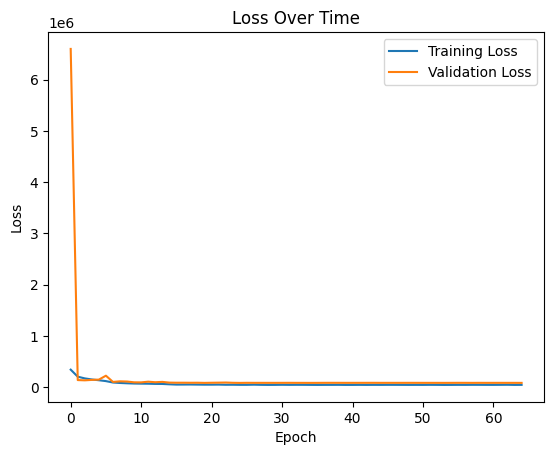

In [ ]:
# Define our training setup
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

#checkpoint_path = "gs://xcob-bucket-1/dataset/model/custom_resnet_weights.h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit model with callbacks
num_epochs = 500  # a larger number for epochs
patience = 40     # an adjusted patience for early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Define the path for GCS checkpoint
#gcs_checkpoint_path = "gs://xcob-bucket-1/dataset/model/custom_resnet_weights/"
#gcs_checkpoint = GCSModelCheckpointUsingGSUTIL(gcs_checkpoint_path)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, local_checkpoint, reduce_lr]
)

# Training complete
print("Training finished.")

# After training, you can analyze or visualize the loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [ ]:
# Path to the pre-trained weights
weights_path = os.path.join('best_model_local', 'model_weights.ckpt')
model.load_weights(weights_path)

In [ ]:
fine_tuned_weights_path = 'fine_tuned_weights.ckpt'
fine_tune_checkpoint = ModelCheckpoint(filepath=fine_tuned_weights_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='min')


In [ ]:
# Unfreeze all layers
for layer in model.layers:
    layer.trainable = True

# Compile the model with a low learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define the checkpoint path again (you might want to use a different name to avoid overwriting)
checkpoint_path = "fine_tuned_weights.ckpt"

# Create the custom checkpoint
#gcs_checkpoint = GCSModelCheckpointUsingGSUTIL(checkpoint_path)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

#model.load_weights(checkpoint_path)

# Add other callbacks if needed (like ReduceLROnPlateau, EarlyStopping, etc.)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[model_checkpoint, reduce_lr, early_stopping]
)

# Save the entire model to a directory
model.save('fine_tuned_model_directory')


Epoch 1/100
696/696 [==============================] - ETA: 0s - loss: 46735.9688 - mean_absolute_error: 119.4871
Epoch 1: val_loss improved from inf to 84898.67969, saving model to fine_tuned_weights.ckpt
696/696 [==============================] - 1502s 554ms/step - loss: 46735.9688 - mean_absolute_error: 119.4871 - val_loss: 84898.6797 - val_mean_absolute_error: 142.2644 - lr: 1.0000e-05
Epoch 2/100
696/696 [==============================] - ETA: 0s - loss: 46181.0742 - mean_absolute_error: 118.5808
Epoch 2: val_loss did not improve from 84898.67969
696/696 [==============================] - 1323s 480ms/step - loss: 46181.0742 - mean_absolute_error: 118.5808 - val_loss: 85670.7578 - val_mean_absolute_error: 142.2386 - lr: 1.0000e-05
Epoch 3/100
696/696 [==============================] - ETA: 0s - loss: 46550.0000 - mean_absolute_error: 119.2877
Epoch 3: val_loss improved from 84898.67969 to 83505.50781, saving model to fine_tuned_weights.ckpt
696/696 [==============================] 

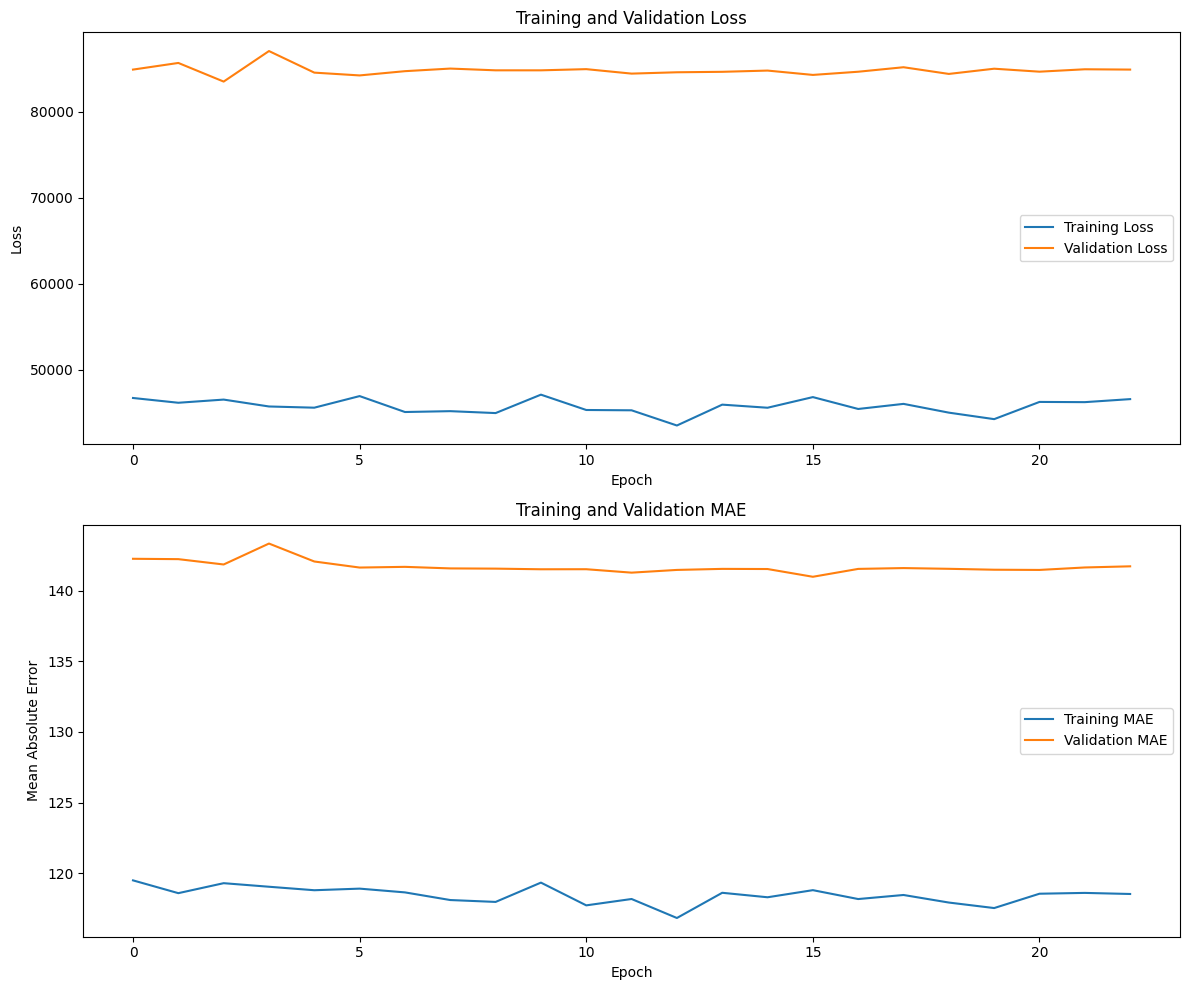

In [ ]:
# Extracting values from the training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
mae_values = history.history['mean_absolute_error']
val_mae_values = history.history['val_mean_absolute_error']

# Setting up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plotting loss values
ax1.plot(loss_values, label='Training Loss')
ax1.plot(val_loss_values, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting MAE values
ax2.plot(mae_values, label='Training MAE')
ax2.plot(val_mae_values, label='Validation MAE')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.legend()

# Displaying the plots
plt.tight_layout()
plt.show()

In [ ]:
#Save finetuned model
model_path_fine_tuned = "fine_tuned_resnet_weights.h5"
model.save(model_path_fine_tuned)

# Use the function you defined earlier to upload back to GCS
gcs_path_fine_tuned = "gs://xcob-bucket-1/dataset/model/fine_tuned_resnet_weights.h5"
upload_model_to_gcs_using_gsutil(model_path_fine_tuned, gcs_path_fine_tuned)


In [ ]:
def download_file_from_gcs(gcs_path, local_path):
    client = storage.Client()
    bucket_name = gcs_path.split("//")[1].split("/")[0]
    blob_name = gcs_path.split(bucket_name + "/")[1]
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_path)

checkpoint_path = "gs://xcob-bucket-1/dataset/model/fine_tuned_resnet_weights.h5"
local_model_path = "downloaded_model.h5"
download_file_from_gcs(checkpoint_path, local_model_path)

model = tf.keras.models.load_model(local_model_path)

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model from the directory
loaded_model = load_model('fine_tuned_model_directory')

# Use the loaded_model to make predictions
predictions = loaded_model.predict(test_dataset)

# Assuming you can extract y_test (the ground truth) from your test_dataset:
y_test_list = []
for _, label_batch in val_dataset:
    y_test_list.extend(label_batch.numpy())
y_test = np.array(y_test_list)

# Define the threshold for binarisation
threshold = 0.5

from scipy.ndimage import label

def count_buildings(binary_mask):
    labeled_mask, num_features = label(binary_mask)
    return num_features

total_predicted_building_count = 0
total_actual_building_count = 0

for idx in range(len(y_test)):
    binary_predictions = (predictions[idx] > threshold).astype(int)
    predicted_building_count = count_buildings(binary_predictions)
    actual_building_count = count_buildings(y_test[idx])
    total_predicted_building_count += predicted_building_count
    total_actual_building_count += actual_building_count
    print(f"Sample {idx}: {predicted_building_count} buildings predicted and {actual_building_count} from ground truths.")

In [ ]:
#Evaluate the model
loss, mae = model.evaluate(val_dataset)
print(f"Test Loss: {loss}, Test MAE: {mae}")

175/175 [==============================] - 234s 1s/step - loss: 83505.5078 - mean_absolute_error: 141.8610
Test Loss: 83505.5078125, Test MAE: 141.8609619140625


In [ ]:
print(f"Total predicted buildings: {total_predicted_building_count}")
print(f"Total actual buildings from ground truths: {total_actual_building_count}")

Total predicted buildings: 10639
Total actual buildings from binary masks: 10055


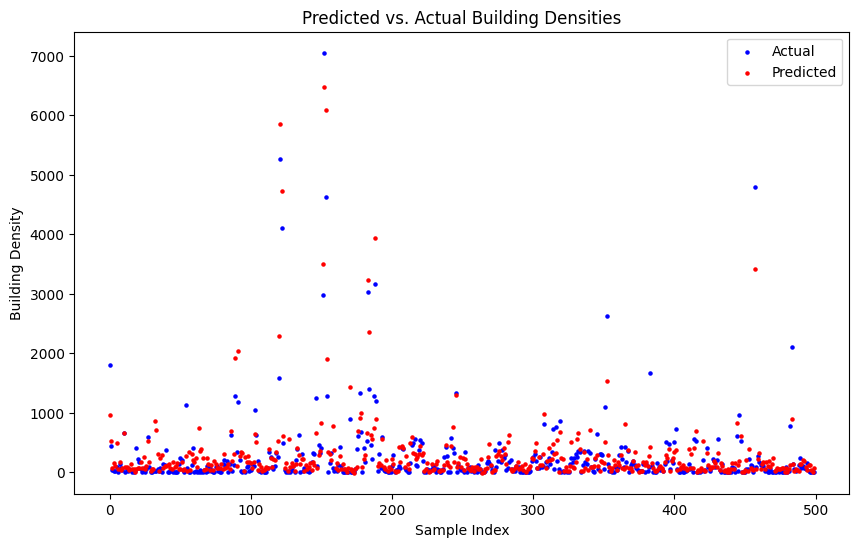

In [ ]:
import matplotlib.pyplot as plt

# Get predicted and actual values
predicted_values = predictions.squeeze()
actual_values = y_test

# Visualise the first 100 samples for clarity
plt.figure(figsize=(10,6))
plt.scatter(range(500), actual_values[:500], color='blue', label='Actual', s=5)
plt.scatter(range(500), predicted_values[:500], color='red', label='Predicted', s=5)
plt.title('Predicted vs. Actual Building Densities')
plt.xlabel('Sample Index')
plt.ylabel('Building Density')
plt.legend()
plt.show()


In [ ]:
print(y_test.shape)
print(predictions.shape)

(11151,)
(11151, 1)


Counting error:
Error
=
(total predicted building count
−
total actual building count) /
total actual building count
×
100
Error=
total actual building count
total predicted building count−total actual building count
​
 ×100

In [ ]:
counting_error_percentage = ((total_predicted_building_count - total_actual_building_count) / total_actual_building_count) * 100
print(f"Counting error: {counting_error_percentage:.2f}%")

Counting error: 5.81%
